In [1]:
from MEM import MEM
from DRC import DRC
from datasets import get_dataset, one_hot_df, get_adults_dataframes
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, mean_absolute_error
from sklearn.linear_model import Lasso
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from scipy.optimize import minimize
from pytan import CLGBayesNetClassifier, DiscreteBayesNetClassifier
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook as tqdm
import warnings

warnings.filterwarnings('ignore')

## Basic experiments

### Datasets

In [2]:
datasets =  ['adult', 'credits', 'kr-vs-kp', 'promoters',  'votes', 'hepatitis']

data = {}

for dataset in datasets:
    X_train, y_train, X_test, y_test = get_dataset(dataset, discrete=True)
    
    df_train = pd.DataFrame(X_train)
    df_test= pd.DataFrame(X_test)
    drops = df_train.loc[:,df_train.apply(pd.Series.nunique) == 1].columns # to handle constant columns in train for TAN
    X_train = df_train.drop(columns = drops).values
    
    print(dataset, X_train.shape)
    X_test = df_test.drop(columns = drops).values
    data[dataset] = (X_train, y_train.squeeze(), X_test, y_test.squeeze())

adult (32561, 101)
credits (517, 187)
kr-vs-kp (2397, 71)
promoters (79, 228)
votes (326, 48)
hepatitis (116, 260)


In [3]:
def process_clf(clf, num_iters, data=data):
    results = [[] for _ in range(len(data))]
    for i in tqdm(range(num_iters)):
        for j, (dataset, sample) in enumerate(data.items()):
            X_train, y_train, X_test, y_test = sample
            clf.fit(X_train, y_train)
            results[j].append(1 - accuracy_score(y_test, clf.predict(X_test)))
    results = np.array(results)
    mean, var = results.mean(axis=1), results.var(axis=1)
    for name, vmean, vvar in zip(data.keys(), mean, var):
        print(f'{name:<15} mean: {vmean:<5}')
    return mean

### SVM

In [4]:
clf = SVC(kernel='linear')
process_clf(clf, 4, data=data)


adult           mean: 0.1781217369940421
credits         mean: 0.12716763005780352
kr-vs-kp        mean: 0.03629536921151444
promoters       mean: 0.11111111111111116
votes           mean: 0.06422018348623848
hepatitis       mean: 0.20512820512820518


array([0.17812174, 0.12716763, 0.03629537, 0.11111111, 0.06422018,
       0.20512821])

### DRC

In [5]:
clf = DRC()
process_clf(clf, 4, data=data)


adult           mean: 0.1724709784411277
credits         mean: 0.10982658959537572
kr-vs-kp        mean: 0.05882352941176472
promoters       mean: 0.14814814814814814
votes           mean: 0.05504587155963303
hepatitis       mean: 0.17948717948717952


array([0.17247098, 0.10982659, 0.05882353, 0.14814815, 0.05504587,
       0.17948718])

### TAN

In [6]:
clf = DiscreteBayesNetClassifier()
process_clf(clf, 4, data=data)


adult           mean: 0.18536944905104114
credits         mean: 0.138728323699422
kr-vs-kp        mean: 0.07259073842302877
promoters       mean: 0.18518518518518523
votes           mean: 0.07339449541284404
hepatitis       mean: 0.1282051282051282


array([0.18536945, 0.13872832, 0.07259074, 0.18518519, 0.0733945 ,
       0.12820513])

### Parameters selection for MEM

In [7]:
# optimal:

# params = {'adult': (0.1, 70),
#  'credits': (0.001, 50),
#  'kr-vs-kp': (0.01, 70),
#  'promoters': (0.1, 20),
#  'votes': (1, 60),
#  'hepatitis': (0.1, 10)}

lambdas = [1e-3, 1e-2, 1e-1, 1, 1e2]
batch_sizes = [10,20,30,40,50,60,70]
results = {}
parameters = {}

for dataset in datasets:
    for lmbda in lambdas:
        for bs in batch_sizes:
            result = process_clf(MEM(lmbda=lmbda, batch_size=bs),  1, data={'data':data[dataset]})
            if dataset in results:
                if result<results[dataset]:
                    results[dataset]=result
                    parameters[dataset] = (lmbda, bs)
                    
            else:
                results[dataset]=result
                parameters[dataset] = (lmbda, bs)


data            mean: 0.6311651618450955



data            mean: 0.2543455561697684



data            mean: 0.2648485965235551



data            mean: 0.24156992813709233



data            mean: 0.275290215588723



data            mean: 0.22388059701492535



data            mean: 0.22762729562066208



data            mean: 0.3755297586143357



data            mean: 0.22560039309624713



data            mean: 0.20514710398624159



data            mean: 0.29519071310116085



data            mean: 0.18008721822983842



data            mean: 0.18930041152263377



data            mean: 0.2036115717707757



data            mean: 0.20858669614888525



data            mean: 0.18045574596155023



data            mean: 0.16982986303052638



data            mean: 0.17044407591671273



data            mean: 0.16921565014434004



data            mean: 0.16854001596953505



data            mean: 0.16854001596953505



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.2362262760272711



data            mean: 0.09248554913294793



data            mean: 0.11560693641618502



data            mean: 0.12138728323699421



data            mean: 0.11560693641618502



data            mean: 0.1329479768786127



data            mean: 0.11560693641618502



data            mean: 0.10404624277456642



data            mean: 0.11560693641618502



data            mean: 0.12138728323699421



data            mean: 0.12138728323699421



data            mean: 0.11560693641618502



data            mean: 0.12138728323699421



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.10982658959537572



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.10982658959537572



data            mean: 0.10982658959537572



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.11560693641618502



data            mean: 0.20231213872832365



data            mean: 0.161849710982659



data            mean: 0.3930635838150289



data            mean: 0.4450867052023122



data            mean: 0.3063583815028902



data            mean: 0.4566473988439307



data            mean: 0.4450867052023122



data            mean: 0.21276595744680848



data            mean: 0.08886107634543183



data            mean: 0.17772215269086356



data            mean: 0.06508135168961204



data            mean: 0.04380475594493116



data            mean: 0.07509386733416767



data            mean: 0.04505632040050067



data            mean: 0.4843554443053817



data            mean: 0.1877346683354193



data            mean: 0.07384230287859828



data            mean: 0.10137672090112637



data            mean: 0.05882352941176472



data            mean: 0.053817271589486904



data            mean: 0.04380475594493116



data            mean: 0.05882352941176472



data            mean: 0.20775969962453067



data            mean: 0.09386733416770965



data            mean: 0.05882352941176472



data            mean: 0.07384230287859828



data            mean: 0.05006257822277849



data            mean: 0.052565707133917394



data            mean: 0.22277847309136423



data            mean: 0.14142678347934923



data            mean: 0.09887359198998746



data            mean: 0.0838548185231539



data            mean: 0.08260325406758451



data            mean: 0.07759699624530658



data            mean: 0.0838548185231539



data            mean: 0.4818523153942428



data            mean: 0.4818523153942428



data            mean: 0.4818523153942428



data            mean: 0.4806007509386734



data            mean: 0.4806007509386734



data            mean: 0.4806007509386734



data            mean: 0.4806007509386734



data            mean: 0.5555555555555556



data            mean: 0.2962962962962963



data            mean: 0.5925925925925926



data            mean: 0.2962962962962963



data            mean: 0.4814814814814815



data            mean: 0.37037037037037035



data            mean: 0.4444444444444444



data            mean: 0.40740740740740744



data            mean: 0.4814814814814815



data            mean: 0.40740740740740744



data            mean: 0.37037037037037035



data            mean: 0.37037037037037035



data            mean: 0.2592592592592593



data            mean: 0.37037037037037035



data            mean: 0.2222222222222222



data            mean: 0.2222222222222222



data            mean: 0.40740740740740744



data            mean: 0.33333333333333337



data            mean: 0.2962962962962963



data            mean: 0.33333333333333337



data            mean: 0.2962962962962963



data            mean: 0.14814814814814814



data            mean: 0.11111111111111116



data            mean: 0.11111111111111116



data            mean: 0.11111111111111116



data            mean: 0.11111111111111116



data            mean: 0.11111111111111116



data            mean: 0.18518518518518523



data            mean: 0.2962962962962963



data            mean: 0.18518518518518523



data            mean: 0.2592592592592593



data            mean: 0.14814814814814814



data            mean: 0.2222222222222222



data            mean: 0.2222222222222222



data            mean: 0.11111111111111116



data            mean: 0.4128440366972477



data            mean: 0.06422018348623848



data            mean: 0.05504587155963303



data            mean: 0.06422018348623848



data            mean: 0.06422018348623848



data            mean: 0.06422018348623848



data            mean: 0.07339449541284404



data            mean: 0.1009174311926605



data            mean: 0.06422018348623848



data            mean: 0.06422018348623848



data            mean: 0.06422018348623848



data            mean: 0.05504587155963303



data            mean: 0.06422018348623848



data            mean: 0.06422018348623848



data            mean: 0.07339449541284404



data            mean: 0.04587155963302747



data            mean: 0.04587155963302747



data            mean: 0.06422018348623848



data            mean: 0.06422018348623848



data            mean: 0.05504587155963303



data            mean: 0.05504587155963303



data            mean: 0.07339449541284404



data            mean: 0.05504587155963303



data            mean: 0.05504587155963303



data            mean: 0.06422018348623848



data            mean: 0.03669724770642202



data            mean: 0.04587155963302747



data            mean: 0.04587155963302747



data            mean: 0.11926605504587151



data            mean: 0.12844036697247707



data            mean: 0.12844036697247707



data            mean: 0.11926605504587151



data            mean: 0.12844036697247707



data            mean: 0.12844036697247707



data            mean: 0.12844036697247707



data            mean: 0.17948717948717952



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.23076923076923073



data            mean: 0.20512820512820518



data            mean: 0.17948717948717952



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.17948717948717952



data            mean: 0.20512820512820518



data            mean: 0.17948717948717952



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.20512820512820518



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564



data            mean: 0.20512820512820518



data            mean: 0.17948717948717952



data            mean: 0.17948717948717952



data            mean: 0.17948717948717952



data            mean: 0.17948717948717952



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564



data            mean: 0.2564102564102564


### Best MEM scores for optimal parameters

In [8]:
results

{'adult': array([0.16854002]),
 'credits': array([0.09248555]),
 'kr-vs-kp': array([0.04380476]),
 'promoters': array([0.11111111]),
 'votes': array([0.03669725]),
 'hepatitis': array([0.17948718])}

In [10]:
parameters

{'adult': (0.1, 60),
 'credits': (0.001, 10),
 'kr-vs-kp': (0.001, 50),
 'promoters': (1, 20),
 'votes': (1, 50),
 'hepatitis': (0.001, 10)}

## Higher dimensionality

In [11]:
from sklearn.linear_model import LogisticRegression

import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
datasets =  ['gisette','synth', 'dota']

data = {}

for dataset in datasets:
    X_train, y_train, X_test, y_test = get_dataset(dataset, discrete=True)    
    print(dataset, X_train.shape)
    data[dataset] = (X_train, y_train.squeeze(), X_test, y_test.squeeze())

gisette (4500, 5000)
synth (150, 10000)
dota (69487, 115)


Consider one have limited train data. How well whould a model perform on a $1/2, 1/4 \dots 1/16$ of data?

In [13]:
results_mem = {}
results_logreg = {}
fractions = [1,2,4, 8, 16]
for frac in fractions:

    data_reduced = {}
    bs = 20
    for dataset in data:

        X, y, X_test, y_test = data[dataset]
        ind = np.random.choice(range(X.shape[0]), X.shape[0]//frac, False)
        Xs = X[ind]
        ys = y[ind]
        
        if Xs.shape[0]<bs:
            bs = Xs.shape[0]

        data_reduced[dataset]=(Xs, ys, X_test, y_test)

    results_mem[frac]=process_clf(MEM(0.1, batch_size=bs), 3, data=data_reduced)
    results_logreg[frac]=process_clf(LogisticRegression(), 3, data=data_reduced)


gisette         mean: 0.030666666666666658
synth           mean: 0.3133333333333333
dota            mean: 0.43821324238368664



gisette         mean: 0.02533333333333332
synth           mean: 0.31999999999999995
dota            mean: 0.39865302421966065



gisette         mean: 0.04355555555555557
synth           mean: 0.3666666666666667
dota            mean: 0.4291326684799033



gisette         mean: 0.031333333333333324
synth           mean: 0.31999999999999995
dota            mean: 0.3996891594353064



gisette         mean: 0.053333333333333344
synth           mean: 0.31999999999999995
dota            mean: 0.42838434860193697



gisette         mean: 0.03600000000000003
synth           mean: 0.31999999999999995
dota            mean: 0.40638086603635104



gisette         mean: 0.06000000000000002
synth           mean: 0.3266666666666666
dota            mean: 0.4631668321604859



gisette         mean: 0.046666666666666634
synth           mean: 0.31999999999999995
dota            mean: 0.40953244398394



gisette         mean: 0.06266666666666665
synth           mean: 0.31999999999999995
dota            mean: 0.46457712731511464



gisette         mean: 0.06533333333333335
synth           mean: 0.31999999999999995
dota            mean: 0.4183827656175798


In [14]:
results_mem

{1: array([0.03066667, 0.31333333, 0.43821324]),
 2: array([0.04355556, 0.36666667, 0.42913267]),
 4: array([0.05333333, 0.32      , 0.42838435]),
 8: array([0.06      , 0.32666667, 0.46316683]),
 16: array([0.06266667, 0.32      , 0.46457713])}

In [15]:
results_logreg

{1: array([0.02533333, 0.32      , 0.39865302]),
 2: array([0.03133333, 0.32      , 0.39968916]),
 4: array([0.036     , 0.32      , 0.40638087]),
 8: array([0.04666667, 0.32      , 0.40953244]),
 16: array([0.06533333, 0.32      , 0.41838277])}

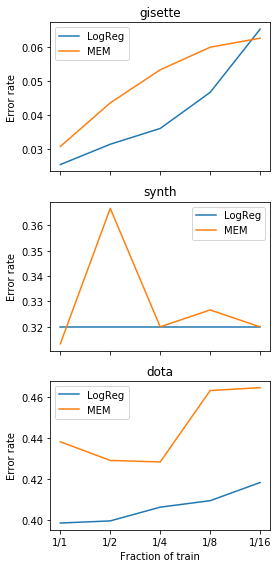

In [16]:
fractions_labels = [f'1/{f}' for f in fractions]

fig, axs = plt.subplots(3,1,sharex=True, figsize=(4,8))
for i in range(3):
    axs[i].plot(np.array(list(results_logreg.values()))[:,i], label = 'LogReg')
    axs[i].plot(np.array(list(results_mem.values()))[:,i], label = 'MEM')
    axs[i].set_title(datasets[i])
    
    
    axs[i].set_ylabel('Error rate')
    axs[i].legend()
plt.xticks(range(5), fractions_labels)
plt.xlabel('Fraction of train')
plt.tight_layout()
    
plt.savefig('additional.png', dpi=100)

### Minimize based implementation

Is much slower and performes worse that mini-batch SGD

In [8]:
# def process_MEM(num_iters, data=data, lmbd = 0.1):

#     def MEM(alpha):
#         w = (y*X)@alpha
#         return np.mean(np.maximum(0,(1-w)*0.5, 1 -w))+lmbd*np.linalg.norm(alpha,ord=2)**2
    
    
#     results = [[] for _ in range(len(data))]
#     for i in tqdm(range(num_iters)):
#         for j, (dataset, sample) in enumerate(data.items()):
#             print(dataset)
#             X_train, y_train, X_test, y_test = sample
#             y = y_train
#             X = X_train
# #             clf.fit(X_train, y_train)
#             res = minimize(MEM, np.ones(X.shape[1]), tol=1e-3, options={'gtol': 1e-02, 'maxiter':100, 'disp':True} )
# #             print(np.sign(X_test@res.x).astype(int))
#             results[j].append(1 - accuracy_score(y_test, np.sign(X_test@res.x).astype(int)))
# #             print(results[j])
#     results = np.array(results)
#     mean, var = results.mean(axis=1), results.var(axis=1)
#     for name, vmean, vvar in zip(data.keys(), mean, var):
#         print(f'{name:<15} mean: {vmean:<5},\t var: {vvar}')